# Introduction
This notebook contains a working example to demonstrate the image classifier black-box interface with the [Video and Image Analytics for Marine Environments (VIAME) Toolkit](https://www.viametoolkit.org/).

We'll apply saliency maps to an underwater fish classification task (the data and models are publicly available on [viame.kitware.com](https://viame.kitware.com), but login or registration may be required). Using [VIAME](https://www.viametoolkit.org/), the trained fish detection and classification models can be used to assess the movement and health of different populations of fish in the ocean. To learn more about this ongoing work, see this [article](https://www.fisheries.noaa.gov/feature-story/science-snapper?fbclid=IwAR3gnTYiPbfdDVDD-LgBUSVc6XYv3Ia9SMerrySZkNx0lpRNB8NFAKF33RE).


We will create an application-like use case where we transform an input image into a number of saliency heatmaps based on our black-box classifier's output, visualizing them over the input image.

This will necessarily include the use of a classification model to perform the role of the black-box classifier that we will be determining the saliency for. We will make use of the [bioharn](https://gitlab.kitware.com/viame/bioharn) package for providing trained, deployable classification models in [PyTorch](https://pytorch.org/). These models are also publicly available as optional add-ons on the [VIAME Github](https://github.com/VIAME/VIAME) page (see the [SEFSC 100-200 Class Fish Models](https://viame.kitware.com/api/v1/item/60b3a58b8438b3b7ffd7032f/download)).

### Table of Contents
* [Set Up Environment](#Set-Up-Environment-VIAME)
* [The Test Image](#The-Test-Image-VIAME)
* [Black-Box Classifier](#Black-Box-Classifier-VIAME)
* [Generating Saliency Maps](#Generating-Saliency-Maps-VIAME)
    * [High-level API](#High-level-API-VIAME)
    * [Calling the Application](#Calling-the-Application-VIAME)

### Miscellaneous
The test image is publicly available on [viame.kitware.com](https://viame.kitware.com) and freely provided by the [Southeast Fisheries Science Center (SEFSC)](https://www.fisheries.noaa.gov/about/southeast-fisheries-science-center).

#### References
1. Zeiler, Matthew D., and Rob Fergus. "Visualizing and understanding convolutional networks." European conference on computer vision. Springer, Cham, 2014.

<br>

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XAITK/xaitk-saliency/blob/master/examples/VIAME_OcclusionSaliency.ipynb)

# Set Up Environment <a name="Set-Up-Environment-VIAME"></a>
**Note for Colab users**: after setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/XAITK/xaitk-saliency/blob/master/examples/README.md#run-the-notebooks-from-colab) for more info).

In [1]:
import sys

# torchvision>=0.13.0 removed "torchvision.models.resnet.model_urls" which is required by
# the download https://data.kitware.com/api/v1/item/62325a614acac99f426f21f8/download (below).
# Because of this we must peg a specific version of torchvision which still has the attribute.
# The pegged torchvision version does not support python 3.11+, so we assert we're using a lower
# python version to prevent package dependency errors.
if sys.version_info > (3, 10):
    raise RuntimeError("Use Python 3.10 or older")
!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q xaitk-saliency
!{sys.executable} -m pip install -q "torch==1.9.0"
!{sys.executable} -m pip install -q "torchvision==0.10.0"
!{sys.executable} -m pip install -q git+https://gitlab.kitware.com/viame/bioharn.git@dev/0.2.0  # test with 0.2.0
# Remove opencv-python, which required libGL, which we don't require here, and replace with opencv-python-headless
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!{sys.executable} -m pip install -q opencv-python-headless

# The Test Image <a name="The-Test-Image-VIAME"></a>
We will test this application on the following image, which contains a [red snapper](https://www.fisheries.noaa.gov/species/red-snapper) or *Lutjanus campechanus*. Images in the dataset were run through a multi-stage pipeline involving fish detection and bounding box generation, followed by image chipping, and finally classification on the generated image chips. An example chipped image is shown below, which is subsequently passed through the trained fish classification model.

Using dir as data root: /home/local/KHQ/elim.schenck/xaitk-saliency/examples/data/viame-example


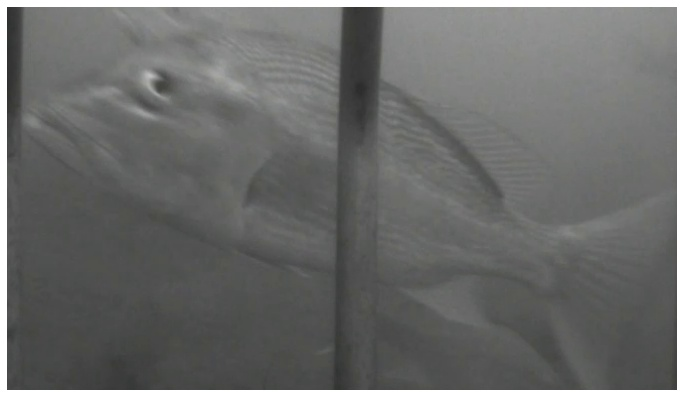

In [2]:
import os
import urllib.request
from collections.abc import Sequence
from typing import Any

import matplotlib.pyplot as plt
import PIL.Image
from typing_extensions import override

# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"


# We'll grab a publicly available fish image
root_dir = "data/viame-example"
print(f"Using dir as data root: {os.path.abspath(root_dir)}")

os.makedirs(root_dir, exist_ok=True)
test_image_filename = os.path.join(root_dir, "fish.png")
if not os.path.isfile(test_image_filename):
    urllib.request.urlretrieve(
        "https://data.kitware.com/api/v1/item/62325a614acac99f426f21f8/download",
        test_image_filename,
    )

plt.figure(figsize=(12, 8))
plt.axis("off")
_ = plt.imshow(PIL.Image.open(test_image_filename))

# Black-Box Classifier <a name="Black-Box-Classifier-VIAME"></a>
We will use [bioharn](https://gitlab.kitware.com/viame/bioharn), a PyTorch-based training and evaluation "harness" (or framework) catered towards biology-related problems. Specifically, we will use the `ClfPredictor` class, which allows for easy use of deployed model and configuration files at inference time.

In this example, we will use a PyTorch-based, ResNeXt101 model trained on fish data and use its softmax output as classification confidences. Although there are ~100 different species or classes of fish, we will, for simplicity of example, only constrain the output to two classes (the ground truth class and the model-predicted class for the test image above).

In [3]:
import zipfile

config_path = "configs/pipelines/models/sefsc_species_resnext_big.zip"
config_model_filepath = os.path.join(root_dir, config_path)

zip_filepath = os.path.join(root_dir, "VIAME-SEFSC-Models.zip")

if not os.path.isfile(config_model_filepath):
    print(f"Downloading model package to {zip_filepath}")
    # Let's first download some models...
    # Note: this may take a while since this is about 5GB of data
    urllib.request.urlretrieve(
        "https://viame.kitware.com/girder/api/v1/item/60b3a58b8438b3b7ffd7032f/download",
        zip_filepath,
    )

    # and then extract the ResNeXt model
    print(f"Extracting relevant configuration/model to {config_model_filepath}")
    zfile = zipfile.ZipFile(zip_filepath)
    zfile.extract(config_path, root_dir)

    os.remove(zip_filepath)
else:
    print(f"Using existing configuration/model: {config_model_filepath}")

Using existing configuration/model: data/viame-example/configs/pipelines/models/sefsc_species_resnext_big.zip


In [4]:
import torch
from bioharn.clf_predict import ClfPredictor

# We make use of the automatic deployed model functionality in bioharn
config = {"deployed": config_model_filepath}
if torch.cuda.is_available():
    # Use our GPU if torch sees CUDA is available.
    config["xpu"] = 0

predictor = ClfPredictor(config)

/home/local/KHQ/elim.schenck/anaconda3/envs/test/lib/python3.9/site-packages/kwimage/structs/boxes.py:82: UserWarning: Optional cython_boxes backend is not available: ValueError('numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject')
  warnings.warn(


We'll set up our "black-box" classifier using bioharn's `ClfPredictor` class, pointing it to the deployed model file we downloaded above. Additionally, we'll wrap this model in smqtk-classifier's `ClassifyImage` interface for standardized classifier operation with our API.

In [5]:
import numpy as np
from smqtk_classifier import ClassifyImage

# Get class names from the predictor model
predictor._ensure_model()  # noqa: SLF001
categories = predictor.coder.classes.class_names

# Choose the ground-truth class ('LUTJANUSCAMPECHANUS-170151107') and the
# predicted class ('PRISTIPOMOIDESAQUILONARIS-170151802') for the test image
sal_class_labels = ["LUTJANUSCAMPECHANUS-170151107", "PRISTIPOMOIDESAQUILONARIS-170151802"]
sal_class_idxs = [categories.index(lbl) for lbl in sal_class_labels]


class FishModel(ClassifyImage):
    """Black-box model based on smqtk-classifier's ClassifyImage."""

    @override
    def get_labels(self) -> Sequence[str]:
        """Return a list of fish labels"""
        return sal_class_labels

    @override
    def classify_images(self, image_iter: np.ndarray) -> dict[str, Any]:
        """Input may either be an NDaray, or some arbitrary iterable of NDarray images."""

        preds = predictor.predict(list(image_iter))
        for p in preds:
            class_conf = p.prob[sal_class_idxs]
            yield dict(zip(sal_class_labels, class_conf))

    @override
    def get_config(self) -> dict[str, Any]:
        """Required by a parent class."""
        return {}


blackbox_classifier = FishModel()

# Choose blackbox_fill value based on model input_norm
model_mean = predictor.model.input_norm.mean.cpu().numpy().flatten()
blackbox_fill = np.uint8(model_mean * 255)

Loading data onto None from <zopen(<_io.BufferedReader name='/tmp/tmp6msr3fzm/deploy_ClfModel_qgsxpjqj_028_GFSDLL/deploy_snapshot.pt'> mode=rb)>
Pretrained weights are a perfect fit


# Generating Saliency Maps <a name="Generating-Saliency-Maps-VIAME"></a>

## High-level API <a name="High-level-API-VIAME"></a>
Here we will use our high-level API interface for visual saliency map generation. Specifically, we will use a sliding-window, occlusion-based saliency map algorithm as well as a debiased [RISE](https://cs-people.bu.edu/vpetsiuk/rise/) saliency algorithm. We can swap in different algorithms and the application will still function successfully due to API consistency, but with different results as per using a different algorithm.

In [6]:
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.rise import RISEStack
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack

gen_slidingwindow = SlidingWindowStack((50, 50), (20, 20), threads=4)
gen_rise = RISEStack(1000, 8, 0.5, seed=0, threads=4, debiased=True)

We will define a helper function for visualizing the generated results, with defined inputs for the following:
  * the image
  * black-box classifier
  * saliency map generation API implementation

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from smqtk_classifier import ClassifyImage

from xaitk_saliency import GenerateImageClassifierBlackboxSaliency


def app(
    image_filepath: str,
    # Assuming outputs `nClass` length arrays.
    blackbox_classifier: ClassifyImage,
    gen_bb_sal: GenerateImageClassifierBlackboxSaliency,
) -> None:
    """Load the image"""
    ref_image = np.asarray(PIL.Image.open(image_filepath).resize((256, 256)))
    sal_maps = gen_bb_sal(ref_image, blackbox_classifier)
    print(f"Saliency maps: {sal_maps.shape}")
    visualize_saliency(ref_image, sal_maps)


def visualize_saliency(ref_image: np.ndarray, sal_maps: np.ndarray) -> None:
    """Visualize the saliency heat-maps"""
    sub_plot_ind = len(sal_maps) + 1
    plt.figure(figsize=(12, 6))
    plt.subplot(2, sub_plot_ind, 1)
    plt.imshow(ref_image)
    plt.axis("off")
    plt.title("Test Image")

    # Some magic numbers here to get colorbar to be roughly the same height
    # as the plotted image.
    colorbar_kwargs = {
        "fraction": 0.046 * (ref_image.shape[0] / ref_image.shape[1]),
        "pad": 0.04,
    }

    for i, class_sal_map in enumerate(sal_maps):
        print(f"Class {i} saliency map range: [{class_sal_map.min()}, {class_sal_map.max()}]")

        # Positive half saliency
        plt.subplot(2, sub_plot_ind, 2 + i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(np.clip(class_sal_map, 0, 1), cmap="jet", alpha=0.3)
        plt.clim(0, 1)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Class #{i+1} Pos Saliency")
        plt.axis("off")

        # Negative half saliency
        plt.subplot(2, sub_plot_ind, sub_plot_ind + 2 + i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(np.clip(class_sal_map, -1, 0), cmap="jet_r", alpha=0.3)
        plt.clim(-1, 0)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Class #{i+1} Neg Saliency")
        plt.axis("off")

## Calling the Application <a name="Calling-the-Application-VIAME"></a>
Here we will show that can invoke the same "application" (helper function) with different `xaitk-saliency` API interface implementations while still successfully executing and visualizing the different results that are generated.

Mount model on GPU(0)
clf predict 1/1... rate=20.39 Hz, eta=0:00:00, total=0:00:00
clf predict  1/43... rate=12.32 Hz, eta=0:00:03, total=0:00:00

/home/local/KHQ/elim.schenck/anaconda3/envs/test/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


clf predict 43/43... rate=15.99 Hz, eta=0:00:00, total=0:00:02
Saliency maps: (2, 256, 256)
Class 0 saliency map range: [-0.9574418663978577, 1.0]
Class 1 saliency map range: [-0.9355486631393433, 1.0]


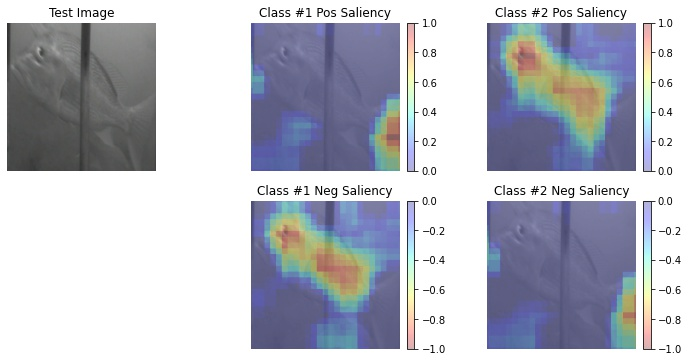

In [8]:
# Set occlusion fill value
gen_slidingwindow.fill = blackbox_fill

app(
    test_image_filename,
    blackbox_classifier,
    gen_slidingwindow,
)

clf predict 1/1... rate=40.00 Hz, eta=0:00:00, total=0:00:00
clf predict 250/250... rate=15.90 Hz, eta=0:00:00, total=0:00:15
Saliency maps: (2, 256, 256)
Class 0 saliency map range: [-0.44653043150901794, 1.0]
Class 1 saliency map range: [-0.438785195350647, 1.0]


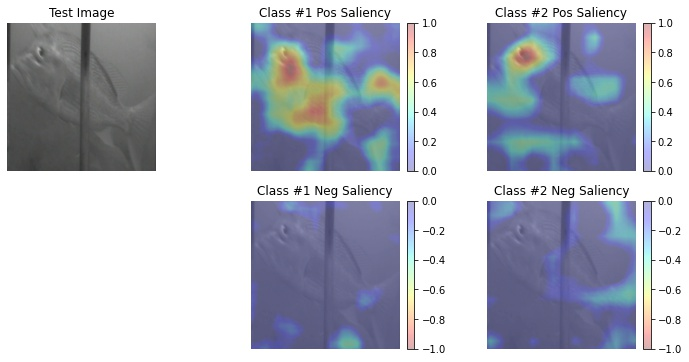

In [9]:
# Set occlusion fill value
gen_rise.fill = blackbox_fill

app(
    test_image_filename,
    blackbox_classifier,
    gen_rise,
)